# Nikshay Jain | MM21B044
## DA5400: Assign 3

In [41]:
import os, csv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from datasets import load_dataset

# Q1

## Preparing dataset

In [42]:
dataset = load_dataset("mnist")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


In [43]:
train_data = dataset['train']
print(train_data)

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})


In [44]:
subset = {i: [] for i in range(10)}
for idx, data in enumerate(train_data):
    label = data['label']
    if len(subset[label]) < 100:
        subset[label].append((data['image'], label))
    if all(len(subset[i]) == 100 for i in range(10)):
        break

final_subset = []
for key in subset:
    final_subset.extend(subset[key])

In [45]:
np.random.shuffle(final_subset)

os.makedirs("data", exist_ok=True)
images = "data\images"
labels = "data\labels.csv"
os.makedirs(images, exist_ok=True)

In [46]:
with open(labels, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Image_Path", "Label"])
    for i, (image, label) in enumerate(final_subset):
        image_path = os.path.join(images, f"image_{i}.png")
        image.save(image_path)
        writer.writerow([image_path, label])

## Part 1(i)

In [47]:
# Directory paths and parameters
image_dir = "./data/images"
labels_csv = "./data/labels.csv"

# Load the images and labels
def load_data(image_dir, labels_csv):
    images = []
    labels = []
    with open(labels_csv, "r") as f:
        rd = csv.reader(f)
        next(rd)      # Skip the header
        for row in rd:
            image_path = row[0]
            label = int(row[1])
            img = Image.open(image_path)
            images.append(np.array(img).flatten())       # Flatten the image into a 1D vector
            labels.append(label)
    return np.array(images), np.array(labels)

# Load the data
images, labels = load_data(image_dir, labels_csv)

In [48]:
def pca(data):
    # Center the data
    mean_vec = np.mean(data, axis=0)
    centered_data = data - mean_vec
    
    cov_matr = np.cov(centered_data, rowvar=False)
    
    # Compute eigenvalues and eigenvectors
    eigenvals, eigenvecs = np.linalg.eigh(cov_matr)
    
    # Sort eigenvalues and eigenvectors in descending order
    sorted_idx = np.argsort(eigenvals)[::-1]
    eigenvals = eigenvals[sorted_idx]
    eigenvecs = eigenvecs[:, sorted_idx]
    
    # checking for direct linear dependecies in parameters
    print('No of eigenvals:', eigenvals.shape)       # gives (784, )
    print('Shape of eigenvecs:', eigenvecs.shape)    # gives (784, 784)
    
    # therefore, no redundancy in data as no of eigen values = dimenstions of data
    
    return eigenvals, eigenvecs, centered_data

In [49]:
def analyse_pca(eigenvals, eigenvecs, centered_data):
    # Calculate explained variance
    tot_var = np.sum(eigenvals)
    expl_var_ratio = eigenvals / tot_var
    cumul_var_ratio = np.cumsum(expl_var_ratio)

    # Find the number of components to cover 95% variance
    n_comps = np.argmax(cumul_var_ratio >= 0.95) + 1

    # Plot the eigenvalues vs princ comps
    plt.plot(range(1, len(eigenvals) + 1), cumul_var_ratio, marker='o', label="Cumulative Variance")
    
    plt.axhline(y = 0.95, color = 'r', linestyle = '--', label = "95% Variance Threshold")
    plt.axvline(x = n_comps, color = 'g', linestyle = '--', label = f"Elbow Point ({n_comps} Components)")
    plt.text(n_comps, 0.5, f"{n_comps} Principal Components", color='black', fontsize=10, 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    
    plt.xlabel("Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Explained Variance vs. No of Components")
    
    plt.legend()
    plt.grid()
    plt.show()

    print(f"No. of principal components (to cover 95% variance): {n_comps}")
    
    # Select the top `n_comps` eigenvectors
    p_comps = eigenvecs[:, :n_comps]
    p_eigenvals = eigenvals[:n_comps]
    
    # Project data onto principal components
    project_data = np.dot(centered_data, p_comps)
    
    return p_comps, p_eigenvals, project_data, n_comps

No of eigenvals: (784,)
Shape of eigenvecs: (784, 784)


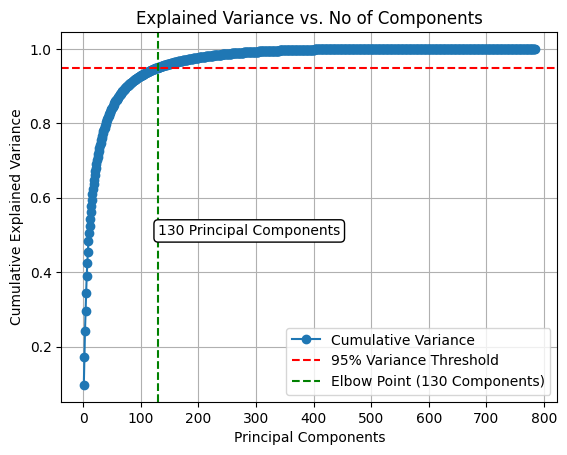

No. of principal components (to cover 95% variance): 130


In [50]:
image_shape = (28, 28)

# Run PCA
eigenvals, eigenvecs, centered_data = pca(images)

p_comps, p_eigenvals, project_data, n_comps = analyse_pca(eigenvals, eigenvecs, centered_data)

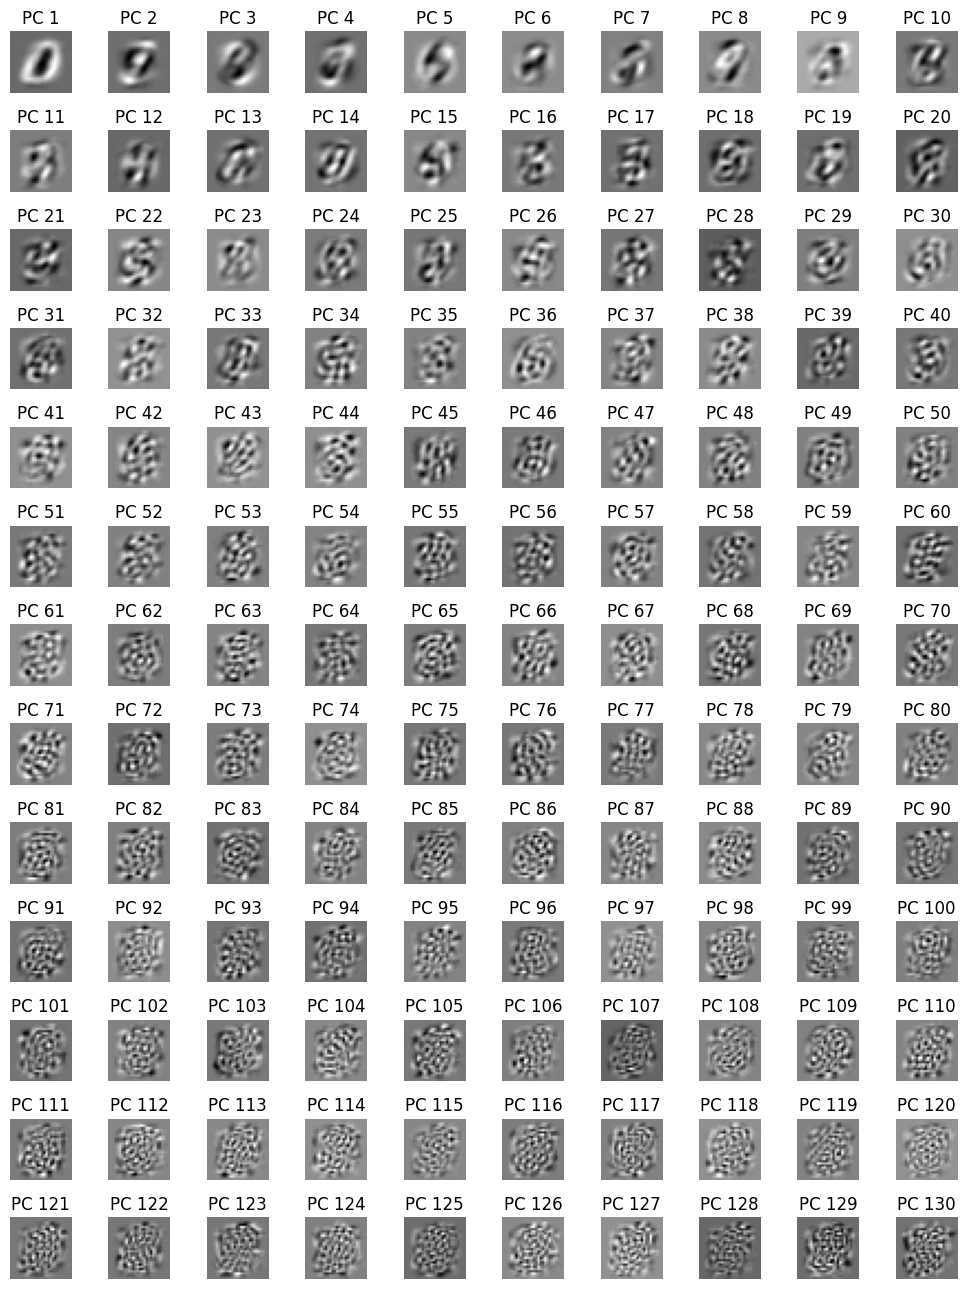

In [51]:
# Visualize principal components as images with reduced sizes
def visualize_p_comp(components, image_shape, n, grid_shape):
    plt.figure(figsize=(10, n // grid_shape[1]))

    for i in range(n):
        # Create a single subplot for each component
        plt.subplot(grid_shape[0], grid_shape[1], i + 1)

        pc_image = components[:, i].reshape(image_shape)
        plt.imshow(pc_image, cmap="gray")
        plt.title(f"PC {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
visualize_p_comp(p_comps, image_shape, n_comps, (n_comps // 10, 10))

In [52]:
# Calc explained variance by each component
def explained_variance(lambdas):
    tot_variance = np.sum(lambdas)
    expl_vars = lambdas / tot_variance
    return expl_vars

expl_vars = explained_variance(p_eigenvals)

for i, var in enumerate(expl_vars[:n_comps]):
    print(f"Variance explained by Principal Component {i+1}: {var*100:.3f}%")
print(f'\nTotal variance explained by all Principal Components: {sum(expl_vars)*100}%')

Variance explained by Principal Component 1: 10.192%
Variance explained by Principal Component 2: 7.826%
Variance explained by Principal Component 3: 7.286%
Variance explained by Principal Component 4: 5.720%
Variance explained by Principal Component 5: 5.136%
Variance explained by Principal Component 6: 4.806%
Variance explained by Principal Component 7: 3.674%
Variance explained by Principal Component 8: 3.190%
Variance explained by Principal Component 9: 2.946%
Variance explained by Principal Component 10: 2.264%
Variance explained by Principal Component 11: 2.137%
Variance explained by Principal Component 12: 2.005%
Variance explained by Principal Component 13: 1.922%
Variance explained by Principal Component 14: 1.805%
Variance explained by Principal Component 15: 1.721%
Variance explained by Principal Component 16: 1.589%
Variance explained by Principal Component 17: 1.367%
Variance explained by Principal Component 18: 1.337%
Variance explained by Principal Component 19: 1.307%
V

## Part 1(ii)

In [53]:
def reconstruct_images(centred_data, eigenvecs, d):
    top_comps = eigenvecs[:, :d]                                # Top d eigenvectors (principal components)
    data_projected = np.dot(centred_data, top_comps)            # Project data into lower-dimensional space
    data_reconstructed = np.dot(data_projected, top_comps.T)    # Reconstruct data from lower dimensions
    return data_reconstructed

In [54]:
def visualize_reconstruction(data_original, data_reconstructed, num_images=3):
    plt.figure(figsize=(10, num_images))
    plt.suptitle("Original vs. Reconstructed Images", fontsize=12)

    for i in range(num_images):
        # Original image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(data_original[i].reshape(28, 28), cmap='gray')  # Assuming 28x28 images
        plt.axis("off")

        # Reconstructed image
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(data_reconstructed[i].reshape(28, 28), cmap='gray')  # Assuming 28x28 images
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Reconstructing dataset using 10 dimensions...


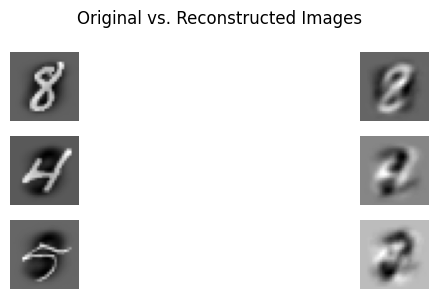

Reconstructing dataset using 20 dimensions...


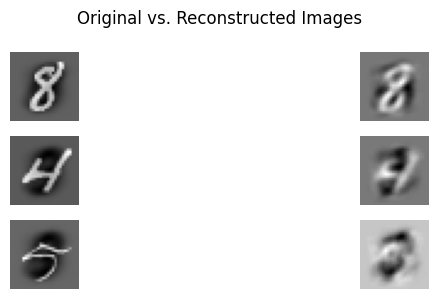

Reconstructing dataset using 50 dimensions...


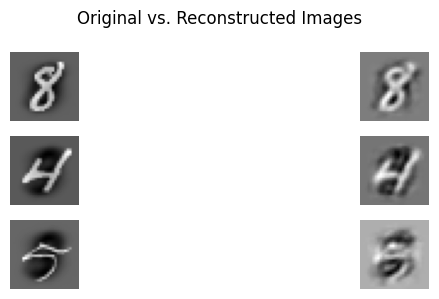

Reconstructing dataset using 100 dimensions...


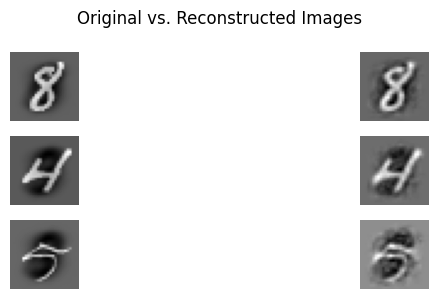

Reconstructing dataset using 130 dimensions...


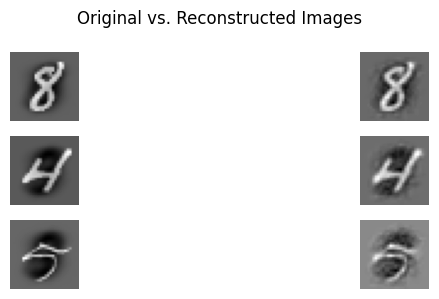

In [55]:
# Reconstruct dataset with different dimensional representations
dim = [10, 20, 50, 100, 130]
recons_err = []

for d in dim:
    print(f"Reconstructing dataset using {d} dimensions...")
    data_reconstructed = reconstruct_images(centered_data, eigenvecs, d)
    visualize_reconstruction(centered_data, data_reconstructed, num_images=3)

    # Calculate reconstruction error (Root Mean Squared Error)
    recons_err.append(np.sqrt(np.mean((centered_data - data_reconstructed) ** 2)))

In [56]:
print("Dimensions \t\tReconstr error")
for i in range(len(dim)):
    print(f"{dim[i]}\t\t\t{recons_err[i]:.4f}")

Dimensions 		Reconstr error
10			46.0730
20			38.1439
50			26.0558
100			17.5086
130			14.5712


## Conclusion:
As it is evident from above plots, we can clearly idetify that the **image contains a number with just top 20 principal components** and the numbers become clearly **distinguishable with top 50** of them.

To reconstruct the images reasonably well, we may go ahead by 50 PCs, but the Reconstruction error table above suggests that going by 130 PCs reduces the error to half of that by 50 PCs. This is also shown as the **elbow** on the graph plotted above which contains **>95% of the information** of the image and the rest components are just remaining 5%.

Therefore, it is safe to use **top 130 components** to get the images reconstructed.

# Q2

## Preparing dataset

In [57]:
data = np.genfromtxt('cm_dataset_2.csv', delimiter=',')
print(data)

[[ -1.2061   -2.5268 ]
 [ -3.7038    0.33831]
 [  4.3444    0.96302]
 ...
 [ -2.8458  -14.469  ]
 [-11.173    -7.4088 ]
 [ -2.3857  -13.212  ]]


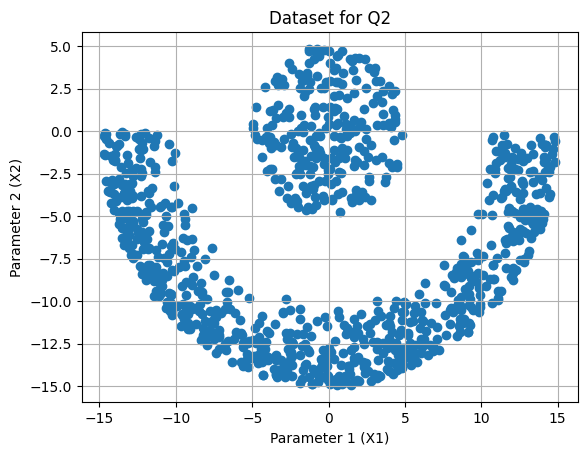

In [58]:
plt.scatter(data[:,0], data[:,1])
plt.title("Dataset for Q2")
plt.xlabel("Parameter 1 (X1)")
plt.ylabel("Parameter 2 (X2)")
plt.grid()
plt.show()

## Part 2(i)

In [59]:
# Lloyd's Algorithm for K-Means
def k_means(data, k, max_iter=100):
    # Randomly initialize k cluster centroids
    n = data.shape[0]
    centroids = data[np.random.choice(n, k, replace=False)]

    error_history = []
    for _ in range(max_iter):
        # Assign each point to the nearest centroid
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        cluster_labels = np.argmin(distances, axis=1)

        # Update centroids as the mean of assigned points
        new_centroids = np.array([data[cluster_labels == j].mean(axis=0) for j in range(k)])

        # Compute error (sum of squared distances to centroids)
        error = np.sum(np.min(distances, axis=1) ** 2)
        error_history.append(error)

        # Convergence check (if centroids don't change)
        if np.allclose(centroids, new_centroids, rtol=1e-6):
            break

        centroids = new_centroids
        
    return cluster_labels, centroids, error_history

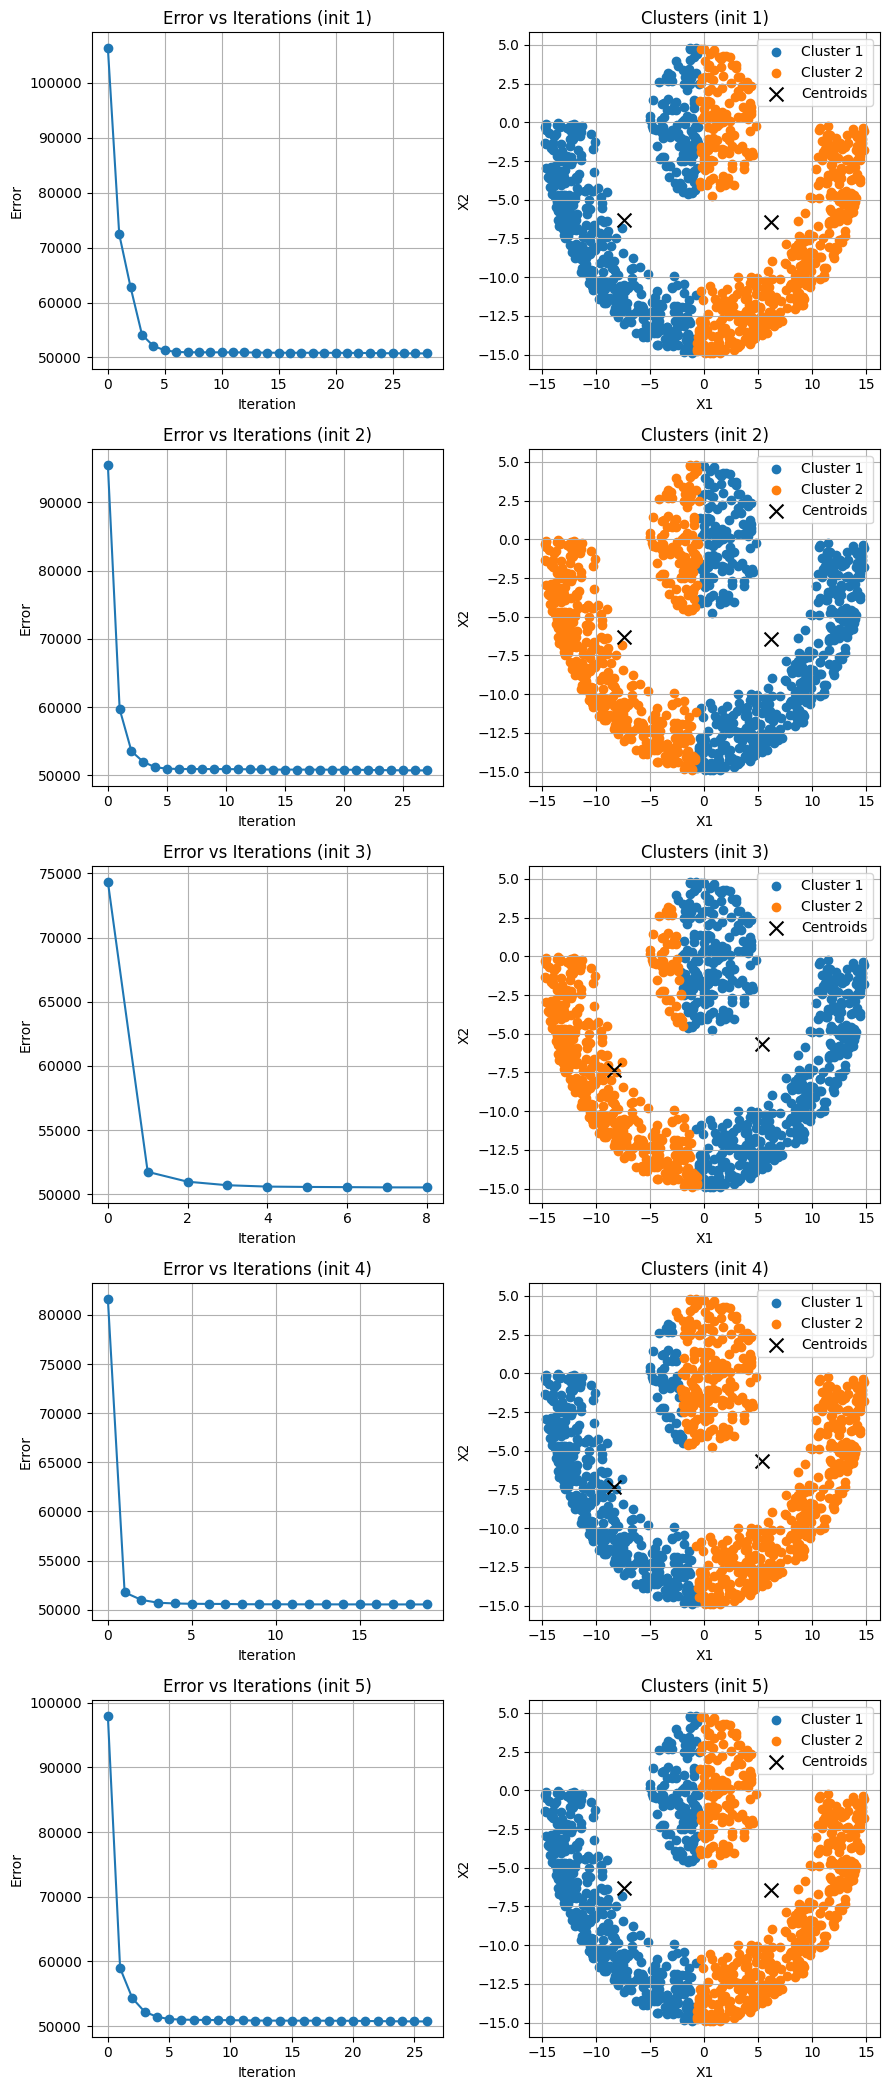

In [69]:
# Run K-Means with 5 random initializations
k = 2
max_iter = 100
n = 5

plt.figure(figsize=(9, 21))

for i in range(n):
    cluster_labels, centroids, error_history = k_means(data, k, max_iter=max_iter)

    # Plot error history
    plt.subplot(5, 2, 2 * i + 1)
    plt.plot(range(len(error_history)), error_history, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.title(f'Error vs Iterations (init {i + 1})')
    plt.grid()

    # Plot clusters
    plt.subplot(5, 2, 2 * i + 2)
    for j in range(k):
        cluster_points = data[cluster_labels == j]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {j + 1}')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label='Centroids')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(f'Clusters (init {i + 1})')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

## Part 2(ii)

In [61]:
def k_means_fixed_init(data, k, init_centers, max_iter=100, tol=1e-4):
    centers = init_centers.copy()
    for _ in range(max_iter):
        # Assign points to the nearest center
        distances = np.linalg.norm(data[:, np.newaxis, :] - centers[np.newaxis, :, :], axis=2)
        labels = np.argmin(distances, axis=1)
        
        # Update cluster centers
        new_centers = np.array([data[labels == i].mean(axis=0) if np.any(labels == i) else centers[i] for i in range(k)])
        
        # Check for convergence
        if np.linalg.norm(new_centers - centers) < tol:
            break
        centers = new_centers
    return centers, labels

In [62]:
# Voronoi regions computation
def compute_voronoi(data, centers, x_min, x_max, y_min, y_max, n=500):
    x = np.linspace(x_min, x_max, n)
    y = np.linspace(y_min, y_max, n)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    distances = np.linalg.norm(grid_points[:, np.newaxis, :] - centers[np.newaxis, :, :], axis=2)
    voronoi_labels = np.argmin(distances, axis=1)
    return xx, yy, voronoi_labels.reshape(xx.shape)

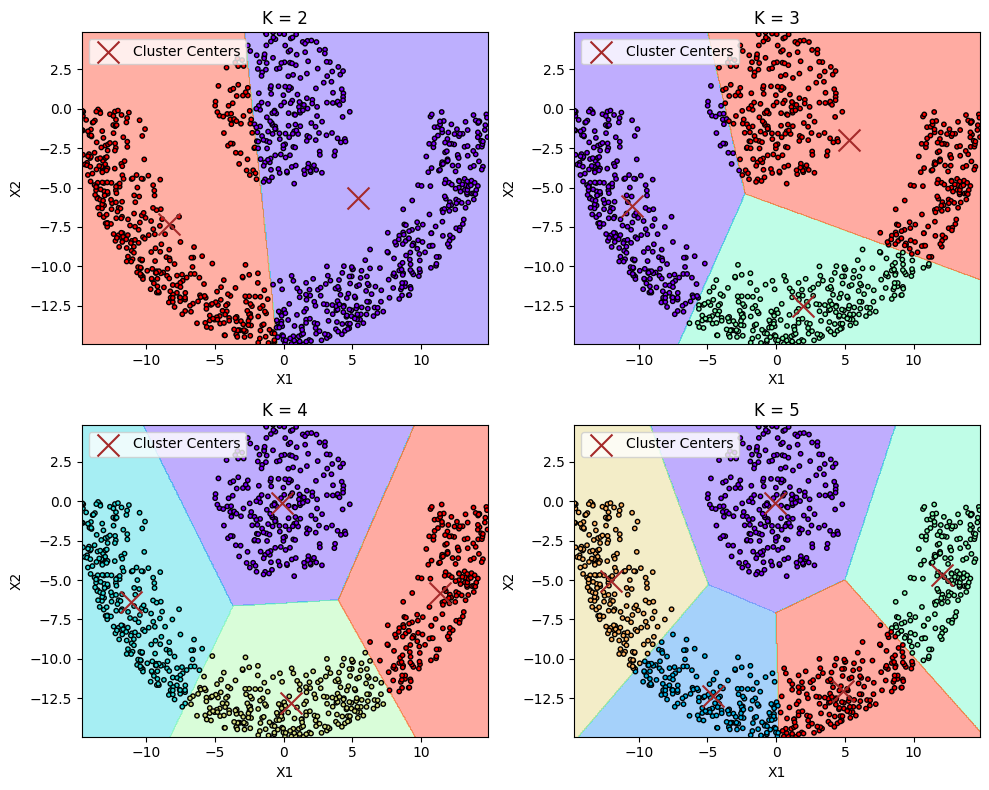

In [63]:
# Main process for each K
k_vals = [2, 3, 4, 5]
x_min, x_max = data[:, 0].min(), data[:, 0].max()
y_min, y_max = data[:, 1].min(), data[:, 1].max()

plt.figure(figsize=(10, 8))
for idx, k in enumerate(k_vals):
    # Fixed initialization
    init_centers = data[np.random.choice(data.shape[0], k, replace=False)]
    
    # Run K-means
    centers, labels = k_means_fixed_init(data, k, init_centers)
    
    # Compute Voronoi regions
    xx, yy, voronoi_labels = compute_voronoi(data, centers, x_min, x_max, y_min, y_max)
    
    # Plot Voronoi diagram
    plt.subplot(2, 2, idx + 1)
    plt.contourf(xx, yy, voronoi_labels, alpha=0.4, cmap=plt.cm.rainbow)
    plt.scatter(data[:, 0], data[:, 1], c=labels, s=10, cmap=plt.cm.rainbow, edgecolor='k')
    plt.scatter(centers[:, 0], centers[:, 1], c='brown', marker='x', s=250, label='Cluster Centers')
    plt.title(f"K = {k}")
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()

plt.tight_layout()
plt.show()

## Part 2(iii)

The Lloyd's algo, which is the standard implementation of the K-means algorithm, is **not** an ideal approach for clustering this datasets due to its non linear decision boundary.

**Some important points to note are:**
1. The lloyd's algo assigns clusters points by **2nd-norm** which creates **linear decision boundaries** for the voronoi region. 
2. This algo assumes clusters are **spherical** in shape which is not the case in this dataset.

**Alternatives for this dataset:**
1. **Kernelised K-Means:** we can extend the given data to higher dimentions using kernel function, where the data becomes linearly seperable (a polynomial kernel of degree 2 would be suitable for this case). Then the standard k means algo would be safely applicable on this data, while still being computationally feasible.

2. **Spectral Clustering:** In spectral clustering, dimensionality reduction is carried out prior to clustering utilizing the eigenvalues of a similarity matrix that is created using data point distances or affinities. This works very well for non-convex or non-linear clusters as in this case.

3. **Gaussian Mixture Models (GMMs):** these are a probabilistic clustering approach that models the data as a mixture of Gaussian distributions. This data can also be modeled well using GMMs. It can handle overlapping clusters as well as non linear decision boundaries between the clusters.

**Summary**
While Lloyd's algorithm is computationally simple and efficient, it is unsuitable for clustering this data due to its reliance on linear decision boundaries. **Kernel-based approaches** or **Spectral Clustering** should be preferred for such problems to effectively capture non-linear cluster structures.